In [9]:
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt

In [24]:
%run utils.ipynb
%run gcn_model.ipynb
%run GAT_model.ipynb
%run FeatureAggregationModel.ipynb

In [3]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [4]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
labels_new = labels[labels["class"] != "unknown"]
nodes_new =  nodes.take(indexes)
edges_new = edges.loc[edges["txId1"].isin(labels_new["txId"])].loc[edges["txId2"].isin(labels_new["txId"])]
nodes_new.shape, labels_new.shape, edges_new.shape

((46564, 167), (46564, 2), (36624, 2))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
data, graph_info = time_step_split(nodes_new, edges_new, labels_new, device)
for key in data:
    print(key, len(data[key]))

train 31
val 5
test 13


In [11]:
GCN = GNN_Example(node_dim=data["train"][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [14]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GCN, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(GCN, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(GCN)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gcn.pt")

Epoch: 10, Loss:0.1898 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.709927    0.951059  0.946978    0.830493      0.946999
recall      0.523810    0.986783  0.946978    0.755297      0.946978
f1-score    0.585383    0.967954  0.946978    0.776668      0.942446
support    98.709677  792.096774  0.946978  890.806452    890.806452
 Train_auc_roc: 0.7552967693191469 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.623936    0.960510   0.93499     0.792223      0.939345
recall       0.723070    0.963188   0.93499     0.843129      0.934990
f1-score     0.653442    0.961536   0.93499     0.807489      0.935821
support    123.400000  942.200000   0.93499  1065.600000   1065.600000
 Val_auc_roc: 0.8431291272312077 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.347624    0.958977  0.928329     0.653301      0.930666
recall      0.299511    0.962739  0.928329   

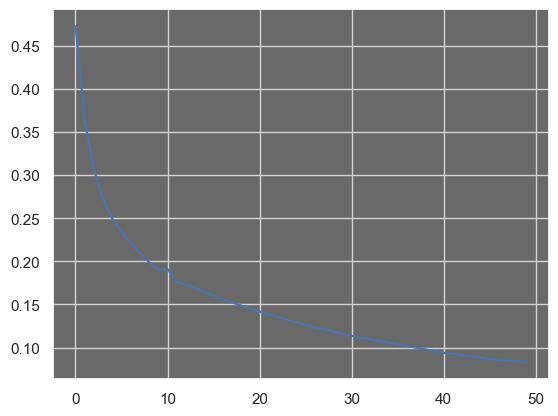

In [15]:
plt.plot(losses)
plt.show()

In [19]:
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

In [20]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GAT.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GAT, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(GAT, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(GAT)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gat.pt")

Epoch: 10, Loss:0.5539 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.508149    0.953906  0.904317    0.731028      0.916304
recall      0.561154    0.927791  0.904317    0.744473      0.904317
f1-score    0.495863    0.939535  0.904317    0.717699      0.906136
support    98.709677  792.096774  0.904317  890.806452    890.806452
 Train_auc_roc: 0.7444725048596612 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.266693    0.975331  0.778497     0.621012      0.910713
recall       0.820329    0.761030  0.778497     0.790680      0.778497
f1-score     0.389133    0.852933  0.778497     0.621033      0.819712
support    123.400000  942.200000  0.778497  1065.600000   1065.600000
 Val_auc_roc: 0.7906799019947716 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.167675    0.980789  0.670679     0.574232      0.932960
recall      0.738613    0.663067  0.670679   

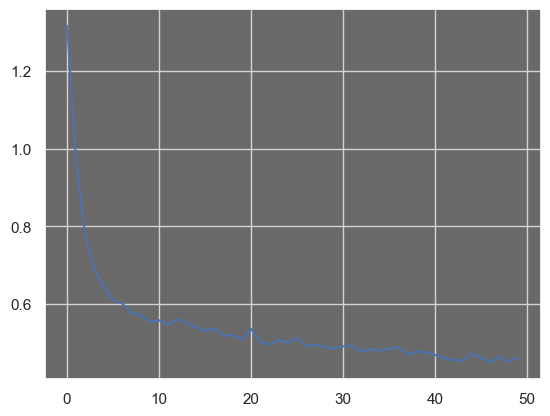

In [21]:
plt.plot(losses)
plt.show()

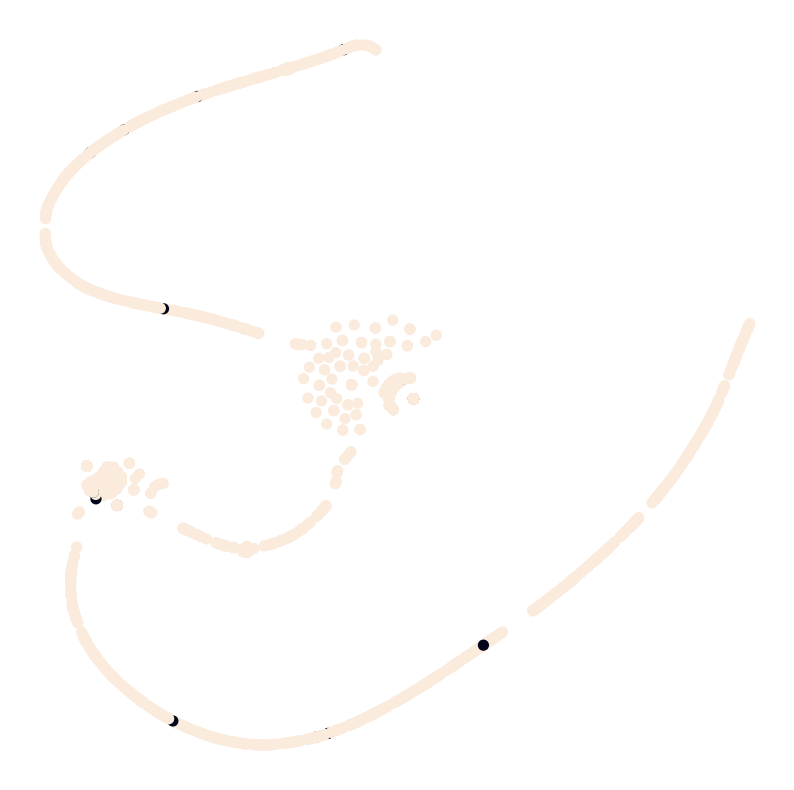

In [64]:
from sklearn.manifold import TSNE

untrained_gat = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

# Get embeddings
h = untrained_gat(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

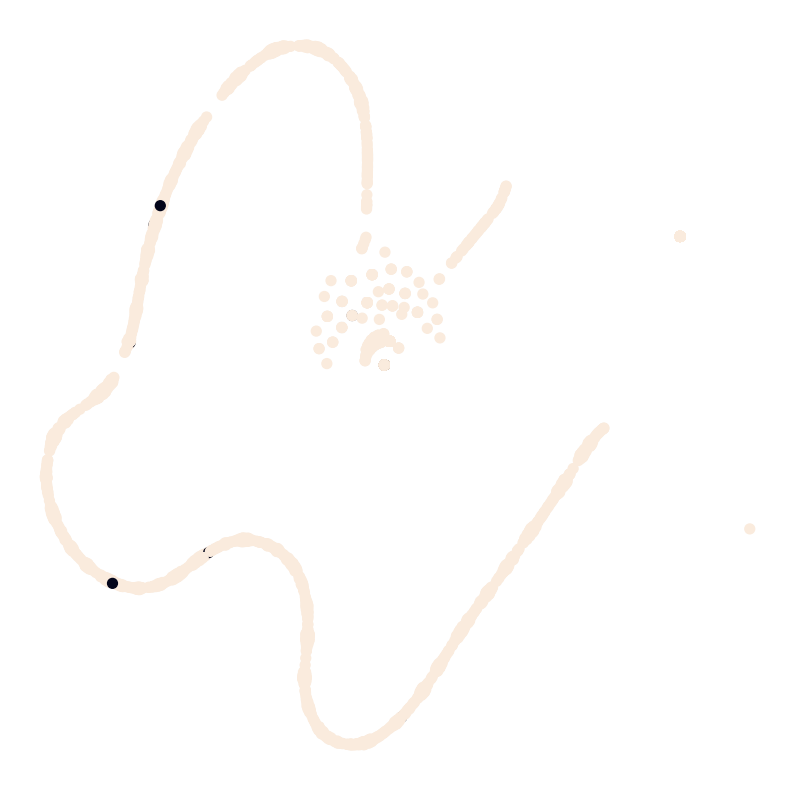

In [66]:
# Get embeddings
checkpoint = torch.load("gat.pt", map_location=device)
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)
GAT.load_state_dict(checkpoint["net"])

h = GAT(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

In [41]:
%run FeatureAggregationModel.ipynb
SFA = SpatialFeatureAggregator(node_dim=data["train"][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [42]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(SFA.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(SFA, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(SFA, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(SFA)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "SFA.pt")

Epoch: 10, Loss:0.2017 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.729367    0.948558  0.947341    0.838962      0.945676
recall      0.530421    0.990433  0.947341    0.760427      0.947341
f1-score    0.603219    0.968484  0.947341    0.785851      0.941792
support    98.709677  792.096774  0.947341  890.806452    890.806452
 Train_auc_roc: 0.7604269888816387 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.849371    0.939381  0.937141     0.894376      0.938481
recall       0.555308    0.991212  0.937141     0.773260      0.937141
f1-score     0.657692    0.963438  0.937141     0.810565      0.928593
support    123.400000  942.200000  0.937141  1065.600000   1065.600000
 Val_auc_roc: 0.7732597481050855 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.437711    0.949107  0.948366     0.693409      0.931704
recall      0.160482    0.997862  0.948366   

In [ ]:
plt.plot(losses)
plt.show()

In [49]:
%run LSTM_GNN.ipynb
TB = TemporalBoy(node_dim=data["train"][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

D:\Python\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [50]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(TB.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(TB, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(TB, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(TB)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "TB.pt")

Epoch: 10, Loss:0.3106 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.085456    0.865980  0.865721    0.475718      0.776111
recall      0.002248    0.999377  0.865721    0.500812      0.865721
f1-score    0.004339    0.924603  0.865721    0.464471      0.807584
support    98.709677  792.096774  0.865721  890.806452    890.806452
 Train_auc_roc: 0.5008123895191725 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.430914    0.896033  0.894236     0.663473      0.867317
recall       0.030802    0.995655  0.894236     0.513229      0.894236
f1-score     0.056144    0.941420  0.894236     0.498782      0.853792
support    123.400000  942.200000  0.894236  1065.600000   1065.600000
 Val_auc_roc: 0.5132287797643095 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.190653    0.935264  0.930714     0.562959      0.898479
recall      0.015984    0.994799  0.930714   

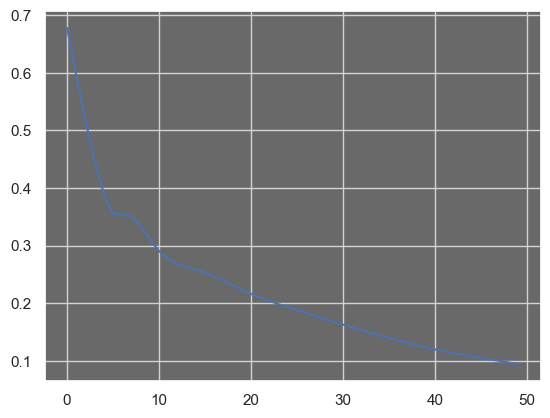

In [51]:
plt.plot(losses)
plt.show()